# Clustering

In the previous chapters we explored unsupervised machine learning models for dimensionality reduction.
Now we will move on to another class of unsupervised machine learning models: clustering algorithms.
Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.

> Clustering is the task of partitioning the data points into natural groups called
clusters, such that points within a group are very similar, whereas points between
different groups are as dissimilar as possible {cite}`zaki2020data`. 

Depending on the data and desired
cluster characteristics, there are different types of clustering paradigms such as
representative-based, hierarchical, density-based, graph-based, and spectral clustering.
Clustering is an unsupervised learning approach since it does not require a separate
training dataset to learn the model parameters.


A brute-force or exhaustive algorithm for finding a good clustering is simply to generate all possible partitions of $n$ points into $k$ clusters, evaluate some optimization score for each of them, and retain the
clustering that yields the best score.
However, this is clearly infeasilbe, since there are
$O(k^n/k!)$ clusterings of $n$ points into $k$ groups. 



Many clustering algorithms are available in Scikit-Learn and elsewhere, but perhaps the simplest to understand is an algorithm known as *k-means clustering*, which is implemented in `sklearn.cluster.KMeans`.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import numpy as np
import warnings
warnings.filterwarnings("ignore")


## Introducing k-Means

The *k*-means algorithm searches for a predetermined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The *cluster center* is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization (see the following figure):

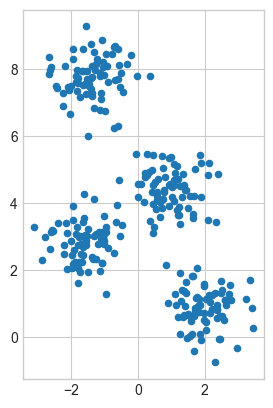

In [2]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)

fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], s=20)
ax.set_aspect('equal')

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels (the following figure).
We will also plot the cluster centers as determined by the *k*-means estimator:

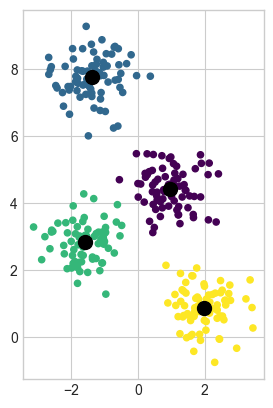

In [4]:
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=20, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=100)
ax.set_aspect('equal')

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly: after all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers.
2. Repeat until converged:
   1. *E-step*: Assign points to the nearest cluster center.
   2. *M-step*: Set the cluster centers to the mean of their assigned points.

Here the *E-step* or *expectation step* is so named because it involves updating our expectation of which cluster each point belongs to.
The *M-step* or *maximization step* is so named because it involves maximizing some fitness function that defines the locations of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.
(For an interactive version of this figure, refer to the code in the online [appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Interactive-K-Means).)

![(run code in Appendix to generate image)](img/05.11-expectation-maximization.png)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Expectation-Maximization)

The *k*-means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation (see the following figure):

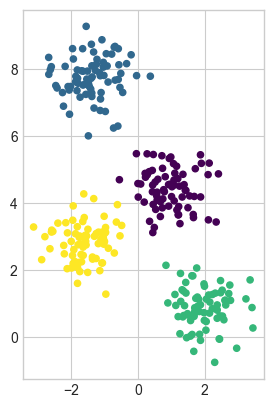

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=20, cmap='viridis')
ax.set_aspect('equal')            

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

There are a few caveats to be aware of when using the expectation–maximization algorithm:

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results (see the following figure):

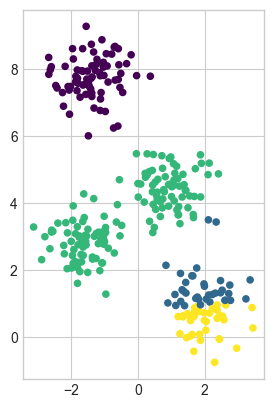

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=20, cmap='viridis')
ax.set_aspect('equal')

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (the number is set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters, as shown in Figure 47-6:

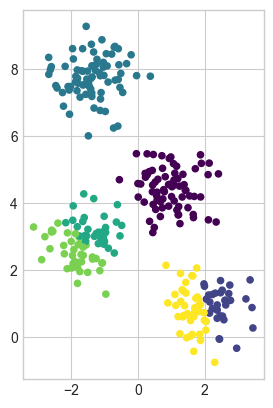

In [7]:
labels = KMeans(6, random_state=0).fit_predict(X)
fig, ax = plt.subplots()
plt.scatter(X[:, 0], X[:, 1], c=labels, s=20, cmap='viridis')
ax.set_aspect('equal')

Whether the result is meaningful is a question that is difficult to answer definitively; one approach that is rather intuitive, but that we won't discuss further here, is called [silhouette analysis](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html).

Alternatively, you might use a more complicated clustering algorithm that has a better quantitative measure of the fitness per number of clusters (e.g., Gaussian mixture models; see [Gaussian Mixture Models](05.12-Gaussian-Mixtures-part1.ipynb)) or which *can* choose a suitable number of clusters (e.g., DBSCAN, mean-shift, or affinity propagation, all available in the `sklearn.cluster` submodule).

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear (such as Case 1 in [Bayesian Decision Theory](05.05-Bayesian-Decision-Theory.ipynb)), which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach (see the following figure):

In [8]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

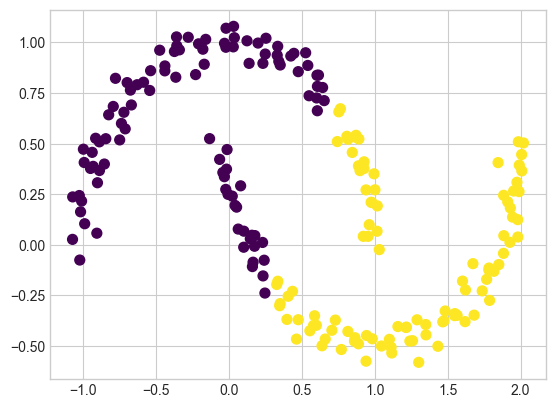

In [9]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

This situation is reminiscent of the discussion in later chapters, where we used a kernel transformation to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator {cite}`Fayaz2015Spectral,Nemati2018Gradient`.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

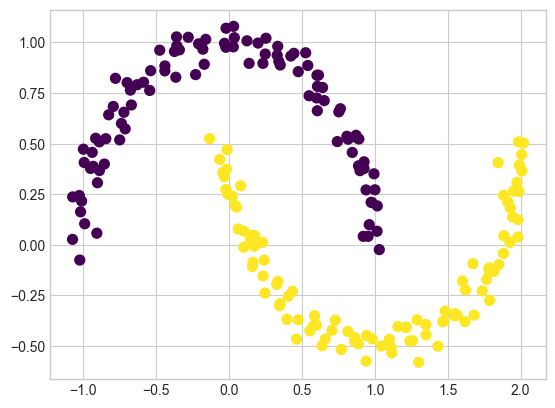

In [10]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)       
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.
You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`.
The interface for this is the same as for standard `KMeans`; we will see an example of its use as we continue our discussion.

## Examples

Being careful about these limitations of the algorithm, we can use *k*-means to our advantage in a variety of situations.
We'll now take a look at a couple of examples.

### Example 1: k-Means on Digits

To start, let's take a look at applying *k*-means on the same simple digits data that we also use  in [ Decision Trees and Random Forests](05.08-Random-Forests.ipynb) and [Principal Component Analysis](05.09-Principal-Component-Analysis-part1.ipynb).
Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.

We will start by loading the dataset, then find the clusters.
Recall that the digits dataset consists of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8 × 8 image:

In [11]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

The clustering can be performed as we did before:

In [12]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can be interpreted as representing the "typical" digit within the cluster.
Let's see what these cluster centers look like (see the following figure):

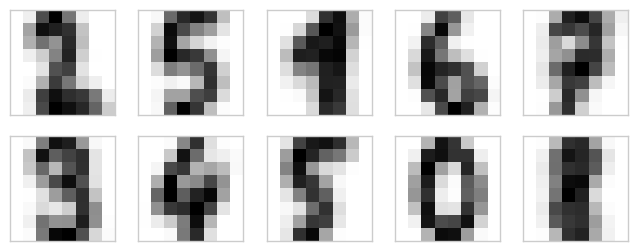

In [13]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identities of the clusters, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in the clusters:

In [14]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [15]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7440178074568725

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this, visualized in the following figure:

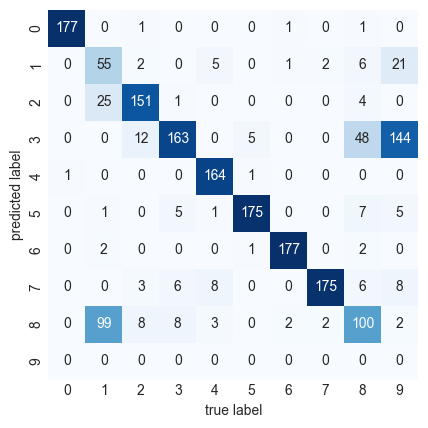

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!

Just for fun, let's try to push this even farther.
We can use the t-distributed stochastic neighbor embedding algorithm (mentioned in [ Manifold Learning](05.10-Manifold-Learning.ipynb)) to preprocess the data before performing *k*-means.
t-SNE is a nonlinear embedding algorithm that is particularly adept at preserving points within clusters.
Let's see how it does:

In [17]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random',
            learning_rate='auto',random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9415692821368948

That's a 94% classification accuracy *without using the labels*.
This is the power of unsupervised learning when used carefully: it can extract information from the dataset that it might be difficult to extract by hand or by eye.

### Example 2: k-Means for Color Compression

One interesting application of clustering is in color compression within images (this example is adapted from Scikit-Learn's ["Color Quantization Using K-Means"](https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html).
For example, imagine you have an image with millions of colors.
In most images, a large number of the colors will be unused, and many of the pixels in the image will have similar or even identical colors.

For example, consider the image shown in the following figure, which is from the Scikit-Learn `datasets` module (for this to work, you'll have to have the `PIL` Python package installed):
(For a color version of this and following images, see the online version of this book).

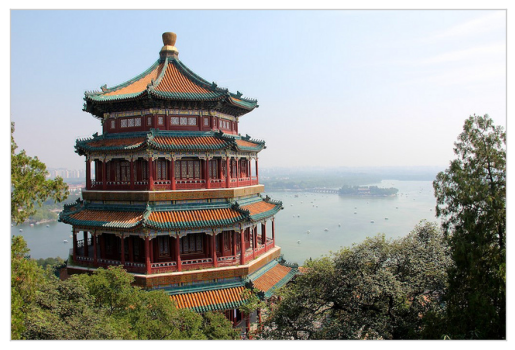

In [18]:
# Note: this requires the PIL package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

The image itself is stored in a three-dimensional array of size `(height, width, RGB)`, containing red/blue/green contributions as integers from 0 to 255:

In [19]:
china.shape

(427, 640, 3)

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space.
We will reshape the data to `[n_samples, n_features]` and rescale the colors so that they lie between 0 and 1:

In [20]:
data = china / 255.0  # use 0...1 scale
data = data.reshape(-1, 3)
data.shape

(273280, 3)

We can visualize these pixels in this color space, using a subset of 10,000 pixels for efficiency (see the following figure):

In [21]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.default_rng(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

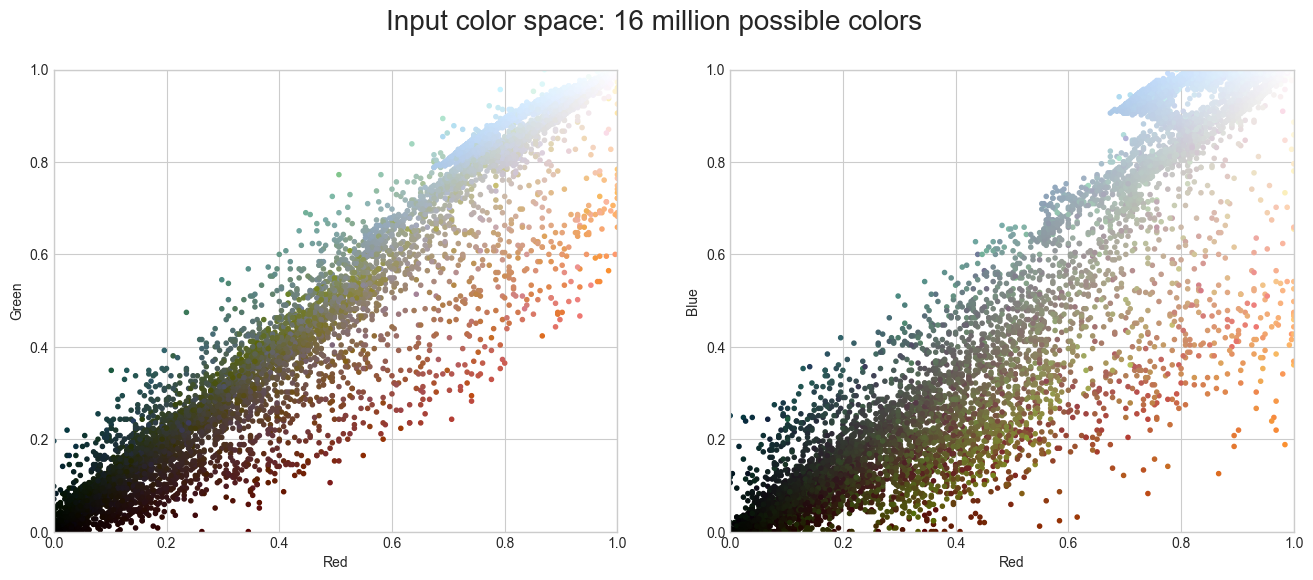

In [22]:
plot_pixels(data, title='Input color space: 16 million possible colors')

Now let's reduce these 16 million colors to just 16 colors, using a *k*-means clustering across the pixel space.
Because we are dealing with a very large dataset, we will use the mini-batch *k*-means, which operates on subsets of the data to compute the result (shown in the following figure) much more quickly than the standard *k*-means algorithm:

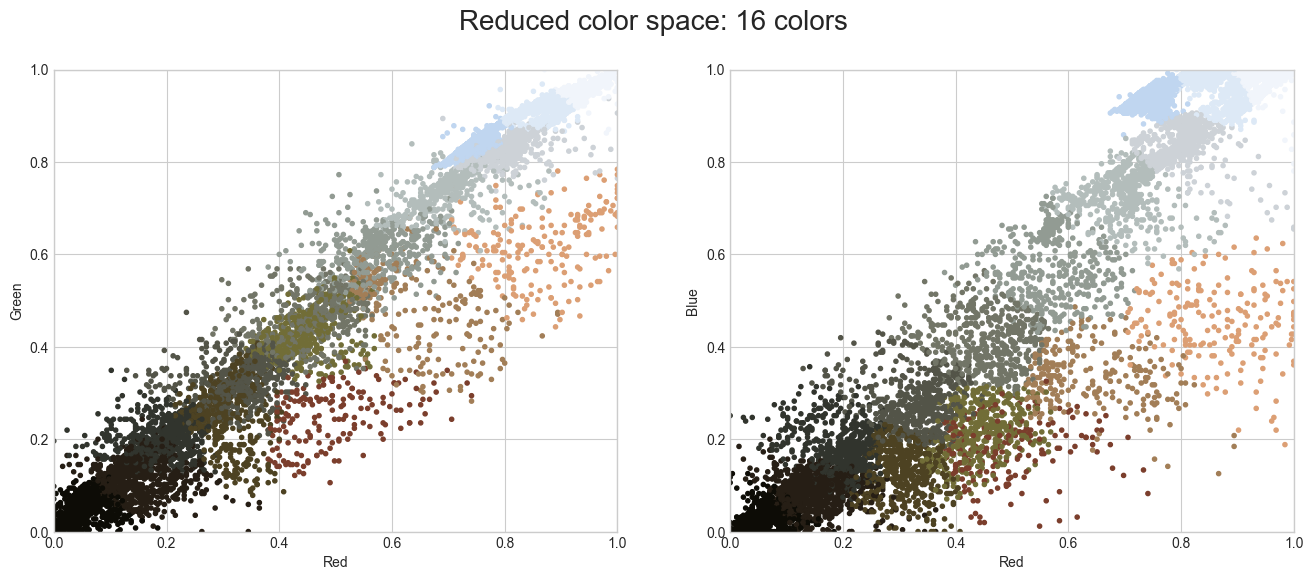

In [23]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

The result is a recoloring of the original pixels, where each pixel is assigned the color of its closest cluster center.
Plotting these new colors in the image space rather than the pixel space shows us the effect of this (see the following figure):

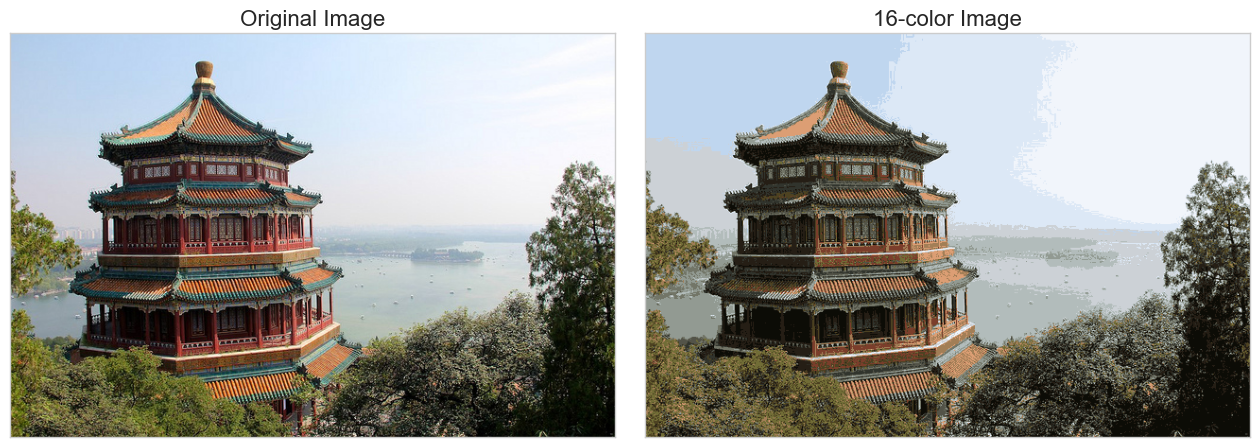

In [24]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

Some detail is certainly lost in the rightmost panel, but the overall image is still easily recognizable.
In terms of the bytes required to store the raw data, the image on the right achieves a compression factor of around 1 million!
Now, this kind of approach is not going to match the fidelity of purpose-built image compression schemes like JPEG, but the example shows the power of thinking outside of the box with unsupervised methods like *k*-means.

## Further Reading

Scikit-learn: [Comparing different clustering algorithms on toy datasets](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)